## This project analyzes contributing factors to terrorist acts from 1970 to 2016. The modeling segment assesses prediction accuracy of four mainstream classifiers, KNeighbors, GaussianNB, Random Forest and Gradient Boost. 

### Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set(style="darkgrid")
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import scale, robust_scale
from sklearn import tree
import plotly
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, KFold, LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score

#### Load data 

In [2]:
terror_df = pd.read_csv('globalterrorismdb_0617dist.csv', usecols=['iyear', 'imonth', 'iday', 'country_txt',  
                     'region_txt', 'city', 'attacktype1_txt', 'success', 'suicide', 'targsubtype1_txt', 
                    'target1', 'natlty1_txt', 'gname', 'individual', 'claimed', 'weaptype1_txt', 
                    'nkill', 'nkillus', 'INT_ANY'])
terror_df.columns = ['year', 'month', 'day', 'country', 
                     'region', 'city', 'suicide', 'success', 'attack_type', 'target_subtype', 
                     'target_type', 'target_nationality', 'group', 'individual', 'claimed', 'weapon', 
                     'fatalities', 'us_fatalities', 'international']
terror_df = terror_df[terror_df.group != 'Unknown']

In [3]:
terror_df.head(3)

,year,month,day,country,region,city,suicide,success,attack_type,target_subtype,target_type,target_nationality,group,individual,claimed,weapon,fatalities,us_fatalities,international
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,1,0,Assassination,Named Civilian,Julio Guzman,Dominican Republic,MANO-D,0,NaN,Unknown,1.0,NaN,0
1,1970,0,0,Mexico,North America,Mexico city,1,0,Hostage Taking (Kidnapping),"Diplomatic Personnel (outside of embassy, cons...","Nadine Chaval, daughter",Belgium,23rd of September Communist League,0,NaN,Unknown,0.0,NaN,1
5,1970,1,1,United States,North America,Cairo,1,0,Armed Assault,"Police Building (headquarters, station, school)",Cairo Police Headquarters,United States,Black Nationalists,0,0.0,Firearms,0.0,0.0,-9


#### Define function to join date and time columns 

In [4]:
def datemerge(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

#### Pass datemerge function to new date column, convert to datetime index and drop rows with any missing values 

In [5]:
terror_df['date'] = datemerge(terror_df['year'], terror_df['month'], terror_df['day'])
terror_df['date'] = pd.to_datetime(terror_df['date'])
terror_df.index = terror_df.date
terror_df.sort_index(inplace=True)
terror_df = terror_df.dropna(how='any')    

### Exploratory Analysis

In [6]:
# attack count resample by month, 1970-2016
attack_count = terror_df.attack_type.resample('A').count()

#### Plot time series illustrating terrorism frequency, 1970 to 2016; uptick in frequency appears between 1995 and 2000

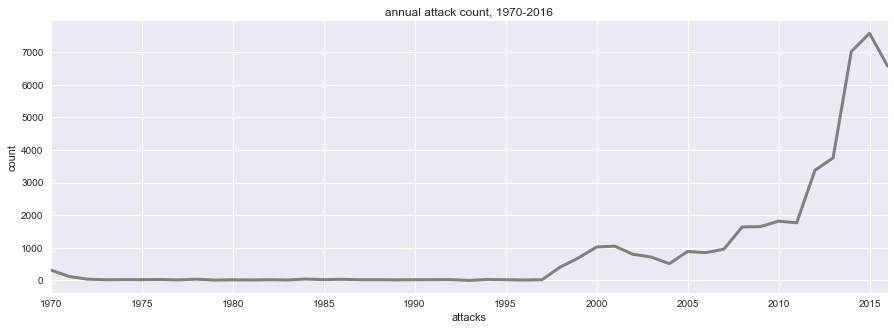

In [7]:
plt.figure(figsize=(15,5))
attack_count.plot(color='grey', linewidth=3)
plt.title('annual attack count, 1970-2016')
plt.ylabel('count')
plt.xlabel('attacks')
plt.show()

#### Horizontal barchart illustrating total fatalities by region, 1970 to 2016; South Asia and MENA show highest incidence rates regionally

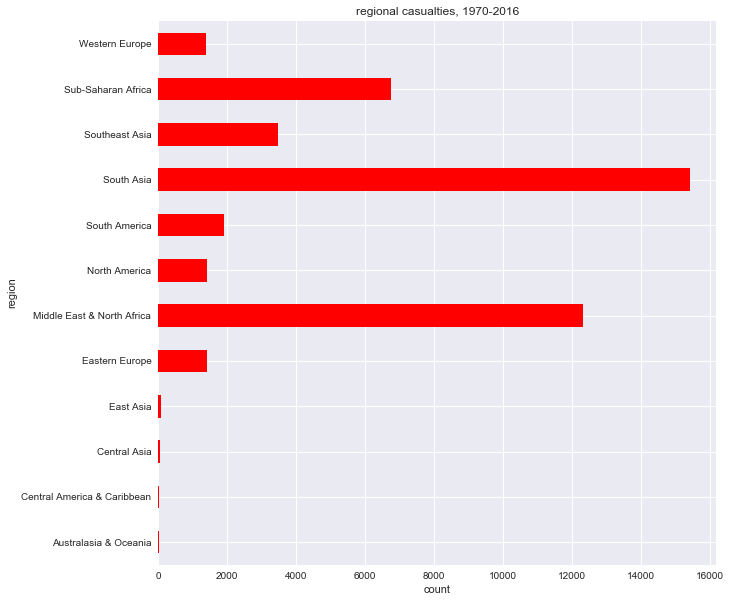

In [9]:
region_count = terror_df.groupby('region')['fatalities'].count()
plt.figure(figsize=(10,10))
plt.title('regional casualties, 1970-2016')
plt.xlabel('count')
plt.ylabel('region')
region_count.plot.barh(color='red')
plt.show()

In [10]:
# top five countries with terror instances by region
country_frequency = terror_df.groupby('region').target_nationality.apply(lambda x: x.value_counts().nlargest(5))
country_frequency

region                                                       
Australasia & Oceania        Australia                             10
                             Fiji                                   3
                             Solomon Islands                        3
                             United States                          2
                             New Zealand                            2
Central America & Caribbean  Haiti                                  8
                             Nicaragua                              3
                             Guatemala                              3
                             Costa Rica                             1
                             Panama                                 1
Central Asia                 Georgia                               18
                             Kazakhstan                             8
                             Tajikistan                             6
                            

#### Horizontal barchart illustrating ten most active terror organizations globally, 1970 to 2016

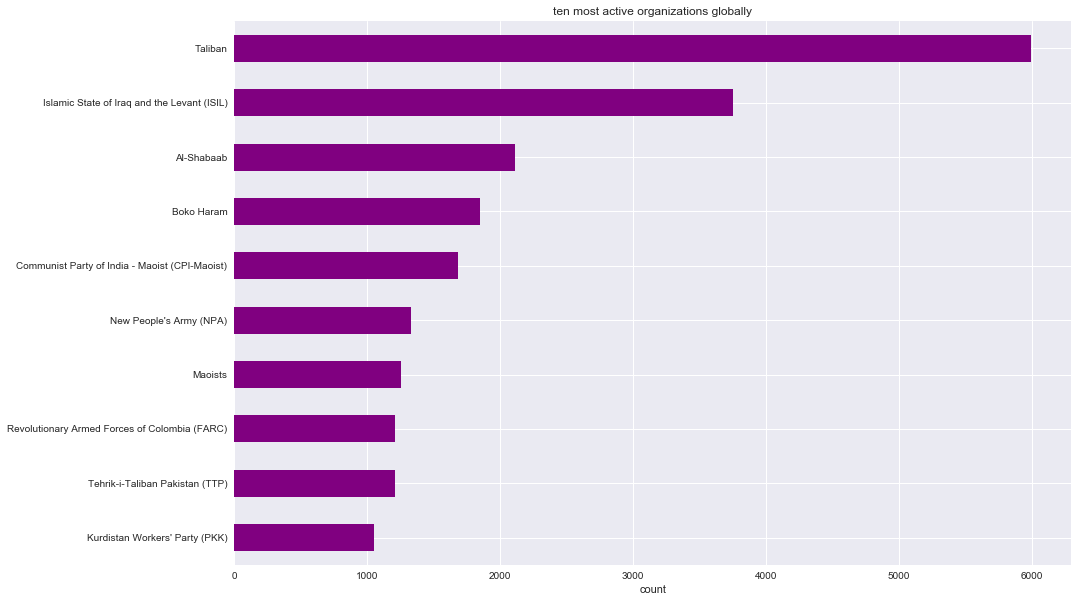

In [14]:
# top groups internationally
top_groups = terror_df['group'].value_counts().nlargest(10).sort_values()
plt.figure(figsize=(15,10))
plt.title('ten most active organizations globally')
plt.xlabel('count')
top_groups.plot.barh(color='purple')
plt.show()

#### Horizontal barchart illustrating total fatality counts per weapon types; explosives/bombs/dynamite and firearms show sweeping popularity

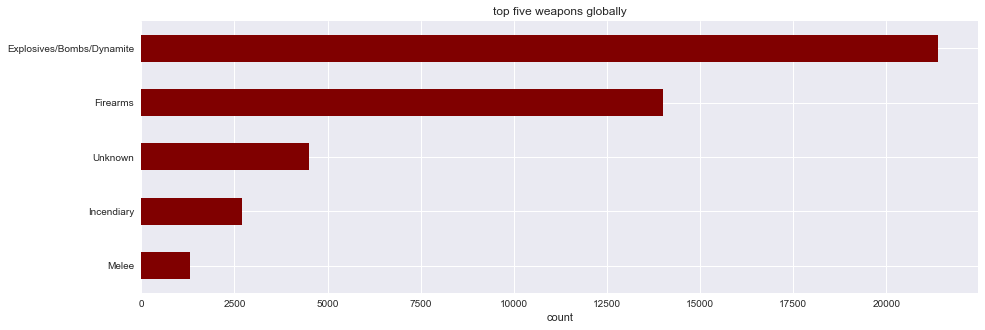

In [15]:
# top five weapons of choice globally
top_attacks = terror_df['weapon'].value_counts().nlargest(5).sort_values()
plt.figure(figsize=(15,5))
plt.title('top five weapons globally')
plt.xlabel('count')
top_attacks.plot.barh(color='maroon')
plt.show()

#### Barchart illustrating result of suicide per terrorist act regionally, 1970 to 2016; results should be considered as associated with, not replacing of, weapon of choice as shown above 

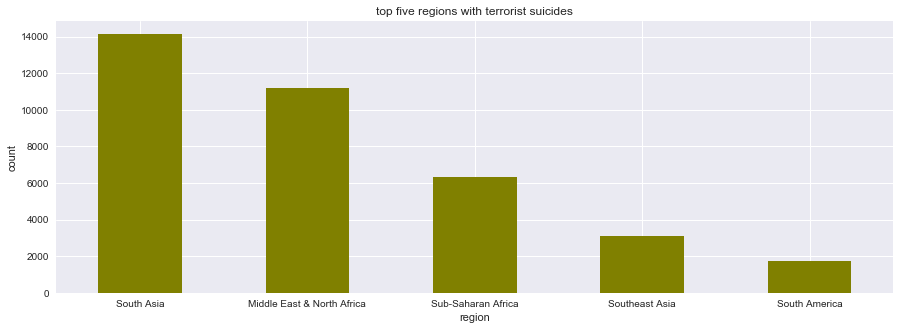

In [18]:
# result in suicide by region
suicide_frequency = terror_df.groupby('region').suicide.sum().nlargest(5)
plt.figure(figsize=(15,5))
plt.title('top five regions with terrorist suicides')
plt.ylabel('count')
suicide_frequency.plot(kind='bar', color='olive')
plt.xticks(rotation=0)
plt.show()

### Preprocessing

In [19]:
# check df shape
terror_df.shape

(44198, 20)

#### Create new df for modeling purposes

In [21]:
model_df = terror_df[['year', 'country', 'target_type', 'attack_type', 'success', 'group']]

#### Check df data types

In [23]:
model_df.dtypes

year            int64
country        object
target_type    object
attack_type    object
success         int64
group          object
dtype: object

#### Fit transform to Label Encoder object; assign X and y variables for train and test data 

In [25]:
le = preprocessing.LabelEncoder()
le.fit(model_df.values.flatten())
encode_df = model_df.apply(le.fit_transform)
X = encode_df.iloc[:, :4]
y = encode_df.iloc[:, 4:5]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=100)
ytrain = ytrain.values.ravel()
print 'Training', 'x:', xtrain.shape, 'y:', ytrain.shape
print 'Testing', 'x:', xtest.shape, 'y:', ytest.shape

Training x: (35358, 4) y: (35358,)
Testing x: (8840, 4) y: (8840, 1)


### Group Classification & Performance Evaluation

#### The following classification algorithms leverage year of event, location of country of attack, target type and success rate (either 1 for yes, 0 for no) for predicting the accused group associated with the unique attacks.

In [26]:
# Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(xtrain, ytrain)
rfc_pred = rfc.predict(xtest)
print 'RFC Accuracy:', (accuracy_score(ytest, rfc_pred) * 100), '%'

RFC Accuracy: 93.32579185520362 %


In [27]:
# KNeighbors Classifier
knc = KNeighborsClassifier()
knc.fit(xtrain, ytrain)
knc_pred = knc.predict(xtest)
print 'KNC Accuracy:', (accuracy_score(ytest, knc_pred) * 100), '%'

KNC Accuracy: 92.88461538461539 %


In [28]:
# Cross Validation of KNeighbors Classifier
numlist = list(range(1,50))
neighbs = filter(lambda x: x % 2 != 0, numlist)
kn_cv_scores = []
for k in neighbs:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xtrain, ytrain, cv=10, scoring='accuracy')
    kn_cv_scores.append(scores.mean())
print 'Cross Validation scores, KNeighbors Classifier:\n'
print kn_cv_scores

Cross Validation scores, KNeighbors Classifier:

[0.9091860294676097, 0.9254478543098574, 0.9315852123371231, 0.9342437674582825, 0.9350356786901199, 0.9350923517465773, 0.9350641432004496, 0.9341025886888434, 0.9343571135711974, 0.9341026206623155, 0.9342157988398603, 0.9342157988398603, 0.933282428914634, 0.9323490589577419, 0.9318399611921121, 0.9311612361198783, 0.9303411003461297, 0.9301996336390161, 0.9301713610961834, 0.9301997296227646, 0.9302280821535623, 0.9301433205125681, 0.9304543665072691, 0.9301998895941708, 0.9303413242961461]


In [29]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=10, max_features=4)
gbc.fit(xtrain, ytrain)
gbc_pred = gbc.predict(xtest)
print 'GBC Accuracy:', round((accuracy_score(ytest, gbc_pred) * 100), 3), '%'

GBC Accuracy: 92.534 %


In [31]:
# Average KFold cross validation of Gradient Boosting Classifier
gbc_kfold = KFold(n_splits=10, random_state=7)
gbc_cv = cross_val_score(gbc, X, y.values.ravel(), cv=gbc_kfold)
print 'GBC Cross Val Mean Score:', round((gbc_cv.mean()*100), 3), '%'

GBC Cross Val Mean Score: 92.724 %


In [32]:
# Gaussian NB Classifier
gnb = GaussianNB()
gnb.fit(xtrain, ytrain)
gnb_pred = gnb.predict(xtest)
print 'GNB Accuracy:', round((accuracy_score(ytest, gnb_pred) * 100), 3), '%'

GNB Accuracy: 92.534 %


In [33]:
# KFold cross validation of Gaussian NB Classifier
gnb_kfold = KFold(n_splits=5, random_state=5)
gnb_cv = cross_val_score(gnb, X, y.values.ravel(), cv=gnb_kfold)
print 'GNB Cross Validation Mean Score:', round((gnb_cv.mean()*100), 3), '%'

GNB Cross Validation Mean Score: 92.724 %


### Conclusions

#### Overall, acts of terrorism show a relatively growing popularity since the start of the twenty first century. South Asia and MENA unsurprisingly show highest incidence rates, with explosives and firearms the preferred weapons of choice. Suicide too shows highest frequencies in South Asia and MENA. 
#### From a modeling standpoint, classification algorithms appear quick and efficient when predicting the organization of unique terror events. Equivalent accuracy scores between specific models may warrant incorporation of additional model features, an initiative which for future research would be beneficial for preemptive counter strategizing. 

### Implications

#### The features selected for predicting terror organizations showed as effective, however specific attributes of the features should be flagged for potential change if leveraged in future studies. Year, for example, holds relevance within the context of the space and period in which the event has occurred; thus, a long term projection of group-specific behavior will depend on the broader timeframe of that group and not just one or more observations. Weapon choice too changes as a function of context and setting given rapid advances in weapon technologies. 